In [2]:
import csv
import cv2 as cv
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import time
# from tensorflow.keras import layers
from PIL import Image
import random

In [3]:
df = pd.read_csv("./dataset/sign_mnist_train.csv", sep=";", encoding="utf-8")

In [20]:
data_aug = tf.keras.Sequential()
data_aug.add(tf.keras.layers.RandomFlip("horizontal"))
data_aug.add(tf.keras.layers.RandomRotation((-0.15, 0.15)))
data_aug.add(tf.keras.layers.RandomBrightness((-0.5, 0.3)))

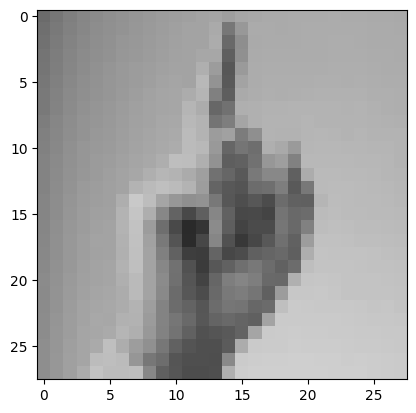

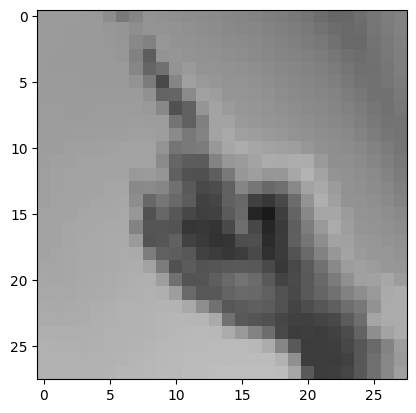

In [6]:
for i in range(100):
    ind = random
    im = df.iloc[i, 1:].to_numpy().reshape((28, 28, 1))
    im2 = data_aug(im.reshape(28, 28, 1))
    plt.imshow(im, cmap='gray', vmin=0, vmax=255)
    plt.show()
    plt.imshow(im2, cmap='gray', vmin=0, vmax=255)
    plt.show()
    break

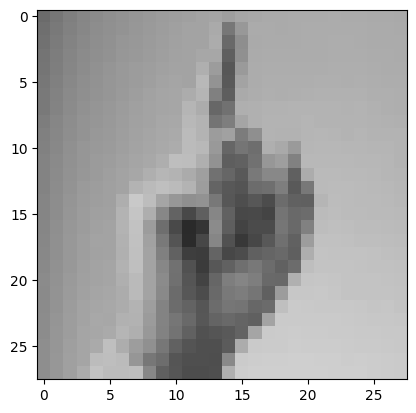

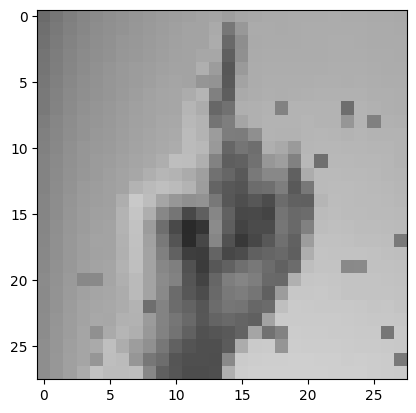

In [17]:
# rajpoute 10% de noise par rapport à la photo originale
df_noise = pd.read_csv("./dataset/sign_mnist_train.csv", sep=";", encoding="utf-8")
df_data = pd.DataFrame(df_noise)
img = df_data.iloc[0, 1:].to_numpy().reshape((28, 28, 1))
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.show()

def add_noise(img):
    img_original = img
    w, h = len(img), len(img)
    pos_pixels = []
    threshold = 125

    for i in range(2, w-1):
        for j in range(2, h-1):
            if img_original[i][j] > threshold:
                pos_pixels.append([i, j+1])

    percent = 0.05
    num_pixels = np.uint(len(pos_pixels)*percent)
    random.shuffle(pos_pixels)
    for item in pos_pixels[:num_pixels]:
        rand = random.randint(110, 150)
        img_original[item[0]][item[1]] = rand
    return np.asarray(img_original).reshape(28,28,1)

noisy_image = add_noise(img)
plt.imshow(noisy_image, cmap='gray', vmin=0, vmax=255)
plt.show()

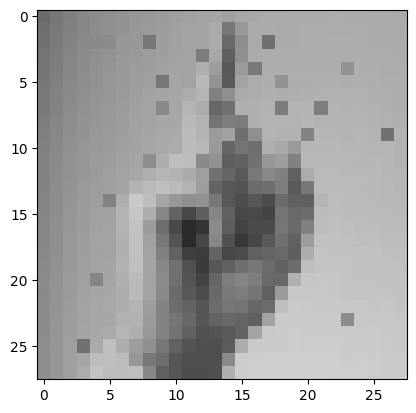

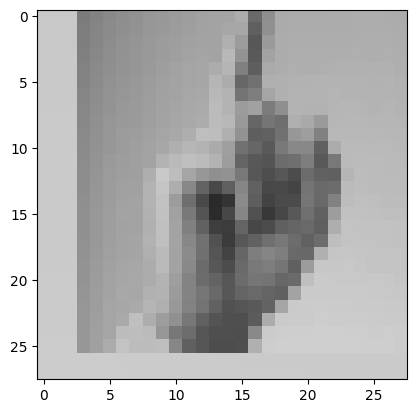

In [14]:
# crop 
df = pd.read_csv("./dataset/sign_mnist_train.csv", sep=";", encoding="utf-8")
df_crop = pd.DataFrame(df)
dim = 28
img_pixels = df_crop.iloc[0, 1:].to_numpy().reshape((dim, dim))
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.show()

def add_cropping(img_p):
    padding = 20
    new_dim = len(img_p) + padding*2
    down_lim, up_lim = padding, len(img_p)+padding
    data_aug = tf.keras.Sequential()
    data_aug.add(tf.keras.layers.Resizing(new_dim, new_dim))

    img_original = [[x for x in item] for item in img_p]

    echantillon = img_p[20:28, 20:28]
    im_augmented = data_aug(echantillon.reshape(8, 8, 1))

    # met la photo dans un plus grand array avec le fond deja dedans
    reshape_img = []
    for i in range(new_dim):
        inner_list = []
        for j in range(new_dim):
            if (i > down_lim and i < up_lim) and (j > down_lim and j < up_lim):
                inner_list.append(img_original[i - down_lim][j - down_lim])
            else:
                inner_list.append(np.uint32(im_augmented[i][j][0]))
        reshape_img.append(inner_list)

    new_image = np.array(reshape_img, dtype="uint32")

    data_crop = tf.keras.Sequential()
    value = random.randint(-8, 8) # gere le degre de positionnement pour le crop
    rand = random.randint(0,1)
    if rand:
        data_crop.add(tf.keras.layers.Cropping2D(cropping=((padding-value,padding+value),(padding-value,padding+value))))
    else:
        data_crop.add(tf.keras.layers.Cropping2D(cropping=((padding-value,padding+value),(padding+value,padding-value))))
    im_augmented = data_crop(new_image.reshape(1, new_dim, new_dim, 1))

    data_crop_back = tf.keras.Sequential()
    data_aug.add(tf.keras.layers.Resizing(dim, dim))
    im_back= data_crop_back(np.asarray(im_augmented))
    return np.asarray(im_back).reshape(28,28,1)

crop_image = add_cropping(img_pixels)
plt.imshow(crop_image, cmap='gray', vmin=0, vmax=255)
plt.show()

In [23]:
# images from camera
cap = cv.VideoCapture(0)
cap.set(cv.CAP_PROP_AUTOFOCUS, 0)
cap.set(cv.CAP_PROP_AUTO_WB, 1)

if not cap.isOpened():
    print("Cannot open camera")
    exit()

last_frame_time = 0
fps = 10
frames = []
x_start, y_start, x_end, y_end = 50, 150, 350, 450
colors = {"blue": (255, 0, 0), "green": (0,255,0)}

lines_coor = [[(x_start, y_start), (x_end, y_start)], [(x_start, y_end), (x_end, y_end)], 
            [(x_start, y_start), (x_start, y_end)], [(x_end, y_start), (x_end, y_end)]]

while True:
    if cv.waitKey(1) == ord('q'):
        break
    ret, frame_full = cap.read()
    
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
    for item in lines_coor:
        cv.line(img=frame_full, pt1=item[0], pt2=item[1], color=colors["blue"], thickness=1, lineType=8, shift=0)
        
    if time.time() - last_frame_time > 1 / fps:
        last_frame_time = time.time()
        frame_full = np.array(frame_full)
        frame = frame_full[y_start : y_end, x_start : x_end, : ]
        frame = np.dot(frame[...,:3], [0.2989, 0.5870, 0.1140]) / 255
        frame_28 = np.asarray(Image.fromarray(frame).resize((28,28)))
        reshape_array = np.array(frame_28).reshape((28,28))

        # add 4 version of the frame
        frames.append(add_noise(reshape_array))
        frames.append(add_cropping(reshape_array))
        frames.append(data_aug(np.array(frame_28).reshape((28,28,1))))
        frames.append(np.array(frame_28))

    if len(frames) > 20:
        break

    cv.imshow('frame', frame_full)

cap.release()
cv.destroyAllWindows()